###In this notebook, I have implemented BERT. Tensorflow tutorial has been followed and suitable changes have been implemented 

Note: I do not recommend using BERT in this case since, the data is limited and BERT models are computationally expensive, Colab GPUs have memory limits which restricts optimal training pipeline

##Step 1: Load the data and import necessary packages

In [ ]:
!cp drive/My\ Drive/finaldata.csv /content

In [ ]:
import pandas as pd
import numpy as np
import os

In [ ]:
data = pd.read_csv('finaldata.csv')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data.head()

NameError: ignored

In [ ]:
data.drop('Unnamed: 0',axis = 1,inplace = True)

##Step 2: Augment Data and 80:20 split into training and validation sets

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dropout,Dense,LSTM,Bidirectional
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

In [ ]:
le = LabelEncoder()
data['Category'] = le.fit_transform(data['Category'])

In [ ]:
trainx,testx,trainy,testy = train_test_split(data['Description'],data['Category'],stratify = data['Category'])

##Step 3:One hot encode target labels

In [ ]:
from tensorflow.keras.utils import to_categorical
train_labels = to_categorical(trainy)
test_labels = to_categorical(testy)

##Step 4: Install required libraries for BERT, as mentioned in the tutorial

In [ ]:
!pip install -q tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 3.4MB 8.4MB/s 
     |████████████████████████████████| 1.1MB 8.0MB/s 
     |████████████████████████████████| 102kB 10.9MB/s 
     |████████████████████████████████| 358kB 26.6MB/s 
     |████████████████████████████████| 37.6MB 76kB/s 
     |████████████████████████████████| 174kB 55.6MB/s 
     |████████████████████████████████| 706kB 56.9MB/s 
     |████████████████████████████████| 645kB 56.6MB/s 
     |████████████████████████████████| 1.2MB 50.3MB/s 
     |████████████████████████████████| 51kB 8.2MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

##Step 5: Select desired BERT model and load the model to runtime

In [ ]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'}
map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'}
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

##Step 6: Define the keras model and add dense layer for inference

In [ ]:
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
net = outputs['pooled_output']
net = tf.keras.layers.Dropout(0.1)(net)
net = tf.keras.layers.Dense(22, activation=None, name='classifier')(net)

In [ ]:
model = tf.keras.Model(text_input, net)

Defining loss, accuracy metric and optimizer (BERT uses Adamw optimizer) 

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.CategoricalAccuracy()

In [ ]:
epochs = 5
num_train_steps = 100 * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

##Step 7: Compile the model and fit on preprocessed data

In [ ]:
model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
hist = model.fit(trainx,train_labels,validation_data = (testx,test_labels),batch_size=32,epochs = 10)

Epoch 1/10
460/460 [==============================] - 483s 1s/step - loss: 1.3244 - categorical_accuracy: 0.6354 - val_loss: 0.1303 - val_categorical_accuracy: 0.9669
Epoch 2/10
460/460 [==============================] - 466s 1s/step - loss: 0.1324 - categorical_accuracy: 0.9670 - val_loss: 0.1285 - val_categorical_accuracy: 0.9667
Epoch 3/10
460/460 [==============================] - 466s 1s/step - loss: 0.1198 - categorical_accuracy: 0.9714 - val_loss: 0.1285 - val_categorical_accuracy: 0.9667
Epoch 4/10
460/460 [==============================] - 465s 1s/step - loss: 0.1292 - categorical_accuracy: 0.9685 - val_loss: 0.1285 - val_categorical_accuracy: 0.9667
Epoch 5/10
460/460 [==============================] - 466s 1s/step - loss: 0.1265 - categorical_accuracy: 0.9695 - val_loss: 0.1285 - val_categorical_accuracy: 0.9667
Epoch 6/10
460/460 [==============================] - 465s 1s/step - loss: 0.1335 - categorical_accuracy: 0.9662 - val_loss: 0.1285 - val_categorical_accuracy: 0.966

Save the model to Google Drive

In [ ]:
model.save('bert')

INFO:tensorflow:Assets written to: bert/assets


INFO:tensorflow:Assets written to: bert/assets


In [ ]:
!cp -r bert drive/My\ Drive

##Step 8: Generate the predictions for the validation set

In [ ]:
preds = list()

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
testcases = testx.reset_index(drop = True)

In [ ]:
for i in tqdm(range(len(testcases))):
  preds.append(tf.nn.softmax(model(tf.constant([testcases[i]]))).numpy().argmax(1)[0])

In [ ]:
from sklearn.metrics import classification_report

##Results and Model Evaluation

It can be seen that the model achieves 88% macro average, much higher than the LSTM model

In [ ]:
n = data['Category'].unique().max()+1

In [ ]:
label_names = []
for i in range(n):
  label_names.append(le.inverse_transform(np.array(i).reshape(-1,1))[0])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:289: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
print(classification_report(testy,preds,target_names=label_names))

                                   precision    recall  f1-score   support

                       Automotive       0.95      0.99      0.97       254
                        Baby Care       0.84      0.88      0.86       121
            Bags, Wallets & Belts       0.88      0.97      0.92        66
         Beauty and Personal Care       0.94      0.98      0.96       178
            Cameras & Accessories       0.91      0.95      0.93        21
                         Clothing       1.00      0.99      0.99      1549
                        Computers       0.93      0.97      0.95       145
                          Eyewear       1.00      0.83      0.91        12
                         Footwear       0.99      1.00      1.00       309
                        Furniture       0.91      0.91      0.91        45
Health & Personal Care Appliances       1.00      0.09      0.17        11
       Home Decor & Festive Needs       0.95      0.97      0.96       233
                  Home F

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix

###Not plotting ROC Curve since, BERT does not support probability prediction (Working on getting the same after completing the task)

In [ ]:
from sklearn.metrics import roc_auc_score,roc_curve

In [ ]:
fpr,tpr,thresh = dict(),dict(),dict()

####Plotting the confusion matrix for the validation set, minor misclassifications can be observed

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
cm = confusion_matrix(testy.values,preds)

In [ ]:
import seaborn as sn

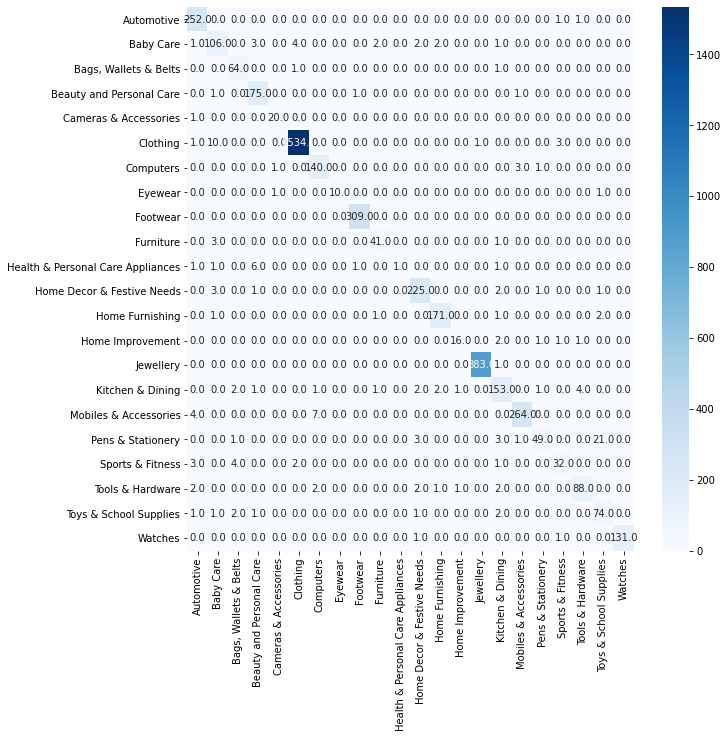

In [ ]:
plt.figure(figsize=(10,10))
sn.heatmap(cm,cmap = 'Blues',annot = True,fmt = '.1f',xticklabels = label_names,yticklabels=label_names)

####Plotting model loss and accuracy, it can be seen that the BERT model achieves optimal performance after 1 epoch itself and further, does not start to overfit on training data. Instead, consistent loss is maintained

In [ ]:
acc = hist.history['categorical_accuracy']
val_acc = hist.history['val_categorical_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(acc) + 1)

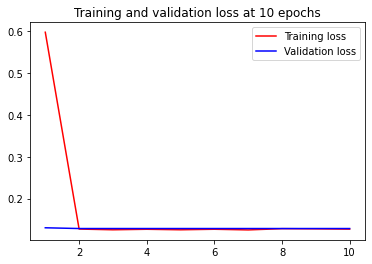

In [ ]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss at 10 epochs')
plt.legend()

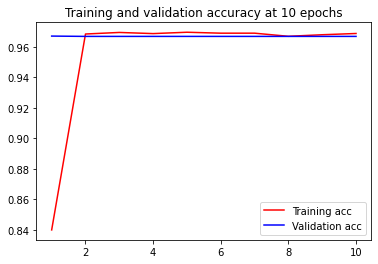

In [ ]:
plt.figure()

plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy at 10 epochs')
plt.legend()

###Conclusion:
The BERT model achieves optimal state after 1 epoch itself although, it takes almost 8 minutes for each epoch. The accuracy achieved is higher than the LSTM model
But, the model would perform if more data is used

###References:
1. BERT Tutorial: https://www.tensorflow.org/tutorials/text/classify_text_with_bert
